In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import pytz
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_parquet(os.path.join('..', 'data', 'traffic.parquet'))

In [3]:
print(len(df.index))

27426840


In [3]:
print(df.head()[['subject_race', 'violation', 'citation_issued']])

  subject_race                                          violation  \
0        white         Drive On Improved Shoulder When Prohibited   
1        white        Speeding-10% or More Above Posted Speed (#)   
2     hispanic    Open Container in Motor Vehicle - Passenger (#)   
3        white                            Speeding Over Limit (#)   
4        white  No/Improper License Plate Lamp|Driving Under t...   

   citation_issued  
0            False  
1             True  
2             True  
3            False  
4             True  


In [4]:
print(df.columns)

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng',
       'county_name', 'district', 'precinct', 'region', 'subject_race',
       'subject_sex', 'officer_id_hash', 'type', 'violation',
       'citation_issued', 'warning_issued', 'outcome', 'contraband_found',
       'contraband_drugs', 'contraband_weapons', 'search_conducted',
       'search_vehicle', 'search_basis', 'vehicle_color', 'vehicle_make',
       'vehicle_model', 'vehicle_type', 'vehicle_year', 'raw_HA_RACE_SEX',
       'raw_HA_SEARCH_PC_boolean', 'raw_HA_SEARCH_CONCENT_boolean',
       'raw_HA_INCIDTO_ARREST_boolean', 'raw_HA_VEHICLE_INVENT_boolean'],
      dtype='object')


In [5]:
df = df[['subject_race', 'violation', 'citation_issued']]

In [6]:
print(df['subject_race'].unique())

['white', 'hispanic', 'black', 'asian/pacific islander', 'unknown', 'other', NaN]
Categories (6, object): ['asian/pacific islander', 'black', 'hispanic', 'white', 'other', 'unknown']


In [7]:
def remove_white_spaces(vio_lst):
  vio_lst = [x.strip() for x in vio_lst]
  return vio_lst

def remove_duplicates(row):
  if row['speeding_only'] == 'speeding-repeated_entries':
    return row['all_violation'][0].strip()
  else:
    return row['violation']

def exclusive(vio_lst):
  count = 0
  for vio in vio_lst:
    # count number of violations containing 'speed'
    if 'speed' in vio:
      count += 1
  # if we have non-speeding violation
  if count < len(vio_lst):
    return 'speeding + others'
  # if we only have speeding violation
  elif count == len(vio_lst):
    # if one speeding vio type
    if count == 1:
      return 'speeding-1'
    # if we have more than one entries but only one type
    elif len(set(vio_lst)) == 1:
      return 'speeding-repeated_entries'
    # if we have more than one type
    else:
      return 'speeding-multiple'
  else:
    return 'undefined case'
    
def speeding_filter(df):
  print('Before speed filtering: ', len(df))
  df['violation'] = [s.lower() for s in df['violation']]
  # at least one violation is speeding-violated (could have other violations at the same time)
  df = df.loc[df['violation'].str.contains('speed', regex = False),:]
  df['violation'] = df['violation'].map(lambda x: x.replace('(#)',''))
  df['violation'] = df['violation'].map(lambda x: x.strip())

  # get a list of violations for each record, and apply self-defined func exclusive
  df['all_violation'] = df['violation'].str.split('|')
  df['all_violation'] = df['all_violation'].map(lambda x: remove_white_spaces(x))
  df['speeding_only'] = df['all_violation'].map(lambda x: exclusive(x))

  # filter out rows with violations other than speeding
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1','speeding-multiple']),:]

  df['violation'] = df.apply(lambda row: remove_duplicates(row), axis = 1)

  df.drop(['all_violation','speeding_only'], axis = 1, inplace = True)
  print('Speeding only violation has records: ', len(df))
  return df

In [8]:
df = speeding_filter(df)

Before speed filtering:  27426840
Speeding only violation has records:  12160826


In [9]:
# Create empty df to store detailed reasults
speeding_citation_df = pd.DataFrame(columns=['Race', 'Total', 'Citation_YES', 'citation_NO', 'citation_percent'])

In [10]:
# Construct dict for insertion
agg_df = df.groupby(['subject_race','citation_issued'], sort=False).size().reset_index(name='Count')
print(agg_df)
agg_df.to_csv('aggregated_citation_numbers_by_race.csv')  

              subject_race  citation_issued    Count
0                    white            False  5474356
1                    white             True  2195902
2                 hispanic            False  1914620
3                 hispanic             True   985459
4                    black            False   702640
5                    black             True   354527
6   asian/pacific islander            False   117518
7   asian/pacific islander             True    97722
8                  unknown            False   204298
9                  unknown             True    95655
10                   other            False    11910
11                   other             True     6145


In [52]:
citation_percent_dict = {}
for subject_race in ['white', 'black', 'hispanic', 'asian/pacific islander']:
    print(subject_race)
    citation_YES = agg_df.loc[(agg_df['subject_race'] == subject_race) & (agg_df['citation_issued'] == True)]['Count'].item()
    print('Citation received:', citation_YES)
    citation_NO = agg_df.loc[(agg_df['subject_race'] == subject_race) & (agg_df['citation_issued'] == False)]['Count'].item()
    print('No citation received:', citation_NO)
    total = citation_YES + citation_NO
    print('Total:', total)
    percent = np.round(citation_YES * 100 / total, 2)
    print('Percentage of drivers who recieved citation:', percent)
    citation_percent_dict[subject_race] = percent

white
Citation received: 2195902
No citation received: 5474356
Total: 7670258
Percentage of drivers who recieved citation: 28.63
black
Citation received: 354527
No citation received: 702640
Total: 1057167
Percentage of drivers who recieved citation: 33.54
hispanic
Citation received: 985459
No citation received: 1914620
Total: 2900079
Percentage of drivers who recieved citation: 33.98
asian/pacific islander
Citation received: 97722
No citation received: 117518
Total: 215240
Percentage of drivers who recieved citation: 45.4


In [53]:
citation_percent_dict

{'white': 28.63,
 'black': 33.54,
 'hispanic': 33.98,
 'asian/pacific islander': 45.4}

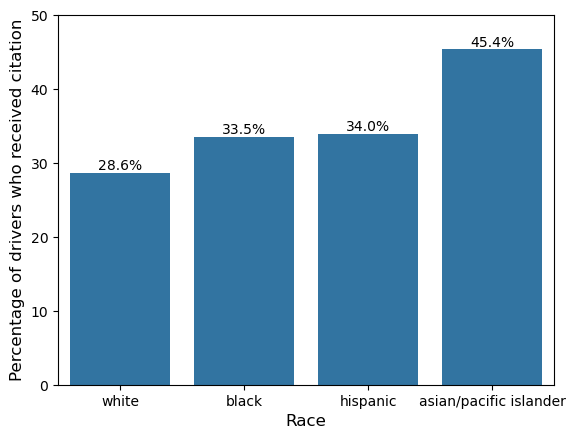

In [65]:
ax = sns.barplot(citation_percent_dict);
plt.ylabel('Percentage of drivers who received citation', fontsize=12);
plt.xlabel('Race', fontsize=12);
ax.bar_label(ax.containers[0], fmt='%.1f%%');
plt.ylim([0,50]);
# ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('citation_percent_by_race.png')
plt.savefig('citation_percent_by_race.pdf')